In [8]:
import sys
sys.path.extend(['E:\\Sue\\parameciums'])

import pandas as pd
import numpy as np
import sqlalchemy as sa
import xcsc_tushare as ts

import matplotlib.pyplot as plt
import seaborn as sns

from paramecium.database import get_sql_engine

import logging

logger = logging.getLogger()
logging.getLogger().setLevel(logging.ERROR)

# 在我的 notebook 里，要设置下面两行才能显示中文
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei', *plt.rcParams['font.sans-serif']]
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# Fama-French三因子模型


## 更新记录
- [2020-06-03].[朱禛仪] v0.1初稿，为了简化模型，HML因子采用Fama原文做法

## TODO List
- 【数据】A股曾用名
- 【数据】股票行业分类

## 参考文献：
1. Eugene, F, Fama,等. Common risk factors in the returns on stocks and bonds[J]. Journal of Financial Economics, 1993.
2. Fama-French三因子回归A股实证 https://mp.weixin.qq.com/s/L5SGFxbMZi7t7JnQk9Dm2w
3. 基金的风格划分及增强FOF组合构建研究 https://mp.weixin.qq.com/s/2m7JXy2RdbRA1SKgFORgKA
4. 中国版的 Fama-French 三因子模型，了解一下？ https://zhuanlan.zhihu.com/p/48728998


## 模型主要形式
$$ r_t - r_f = \alpha_t + \beta_1 MKT_t + \beta_2 SMB_t + \beta_3 HML_t + \varepsilon_t $$

# 1. 股票风格标签

在每个**月末**进行一次风格划分，按照股票的流通市值将股票划分为大盘、中盘、小盘，按照账面市值比将股票定义为价值型、平衡型和成长型，然后两两组合，构成9个股票风格标签。
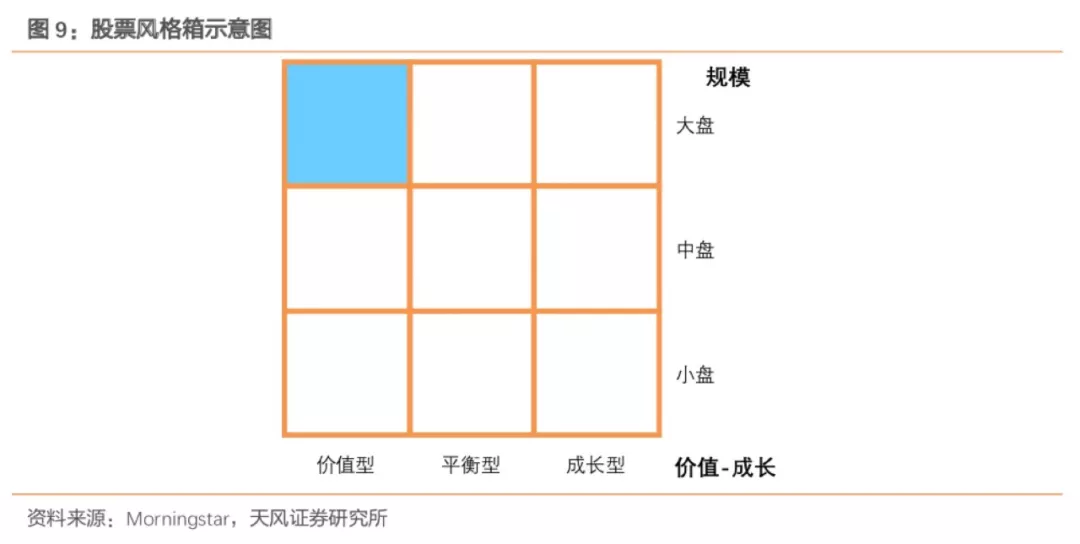

## 1.1 股票筛选

1. 全部A股(tushare接口:`stock_basic`)
2. 月末当天，正常交易 (tushare:`daily` 满足 `trade_status!='停牌'`) 
2. 排除ST股票：当期名称不包含"ST"或者"PT"
3. 剔除次新股 `list_date > 12*31 days`
4. 剔除将摘牌股票 `delist_date < 31 days`

## 1.2 因子合成

因子估值指标采用Wind处理的End-Of-Date估值指标，即tushare接口`daily_basic`

### 规模因子
- 基础字段：流通市值`mv`  
- 计算：$ Size = \ln(流通市值) $

### 价值因子
- 基础字段：`pe_ttm`
- 计算： $ Value = 1 / pe_ttm $

## 1.3 因子数据处理
计算得到在进行去极值(MAD)、空值填充（目前暂无数据，故直接删除缺失股票）后，进行规范化(robust-scale)。

### 规模因子
将规模因子进行降序排列，取第200支股票的规模因子值作为大中盘门限值$MST$，并取第500支股票的规模因子值作为中小盘门限值$LST$，规范化后的因子值：
$$ NormSize = 100 \times \big[ 1 + \frac{Size - MST}{MST - LST} \big] $$

### 价值因子
价值因子采用**双排序**的规范化，即在同一个规模因子风格中取上下三分位点分别为价值-平衡、平衡-成长的门限值$VT$和$GT$，规范化后的因子值：
$$ NormValue = 100 \times \big[ 1 + \frac{Value - VT}{VT - GT} \big] $$

则根据处理后因子得到的股票风格标签如下
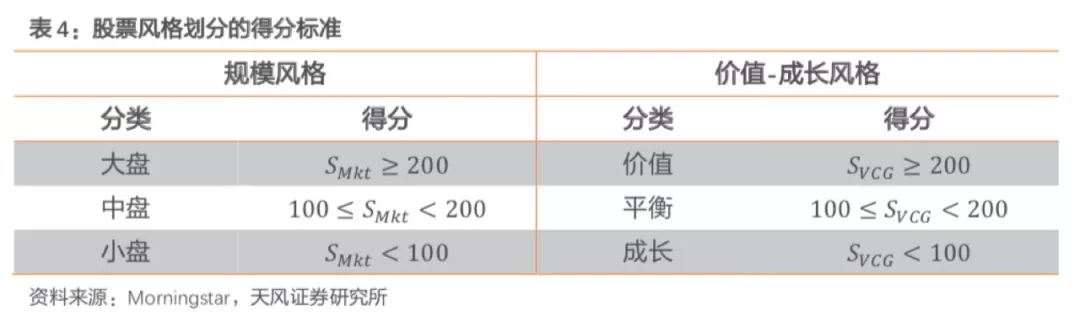


此外，保存股票的原始流通市值用于合成因子，最终入库因子的格式如下，其中股票代码和因子日期应设索引

In [18]:
pd.read_sql(
    """
    select wind_code, trade_dt, size, value, capt, label
    from stock_factor_fama_french
    where trade_dt >= '2009-01-01' and trade_dt<='2019-12-31';
    """,
    get_sql_engine('postgres')
).sample(5)

,wind_code,trade_dt,size,value,capt,label
83195,002074.SZ,2013-08-30,-485.504038,-42.491381,1.124568e+05,SN
15935,600643.SH,2010-03-31,70.442296,-200.108401,8.963661e+05,MG
104849,000530.SZ,2014-06-30,-406.490248,186.036561,2.116934e+05,SV
66251,000768.SZ,2012-11-30,204.343682,-230.098809,1.581634e+06,BG
31389,002069.SZ,2011-03-31,118.404971,-102.071361,1.548249e+06,BG


# 2. 风格因子合成

在每个月末进行一次股票风格划分，在每个风格下按照**流通市值**加权构成投资组合即为风格箱因子。

此处保存因子的累计收益

| benchmark_code | trade_dt  | price     |
| -------------- | ---------- | ----------- |
| ff3_smb      | 2019-05-23 | 2589.969630 |


因子走势如下图：

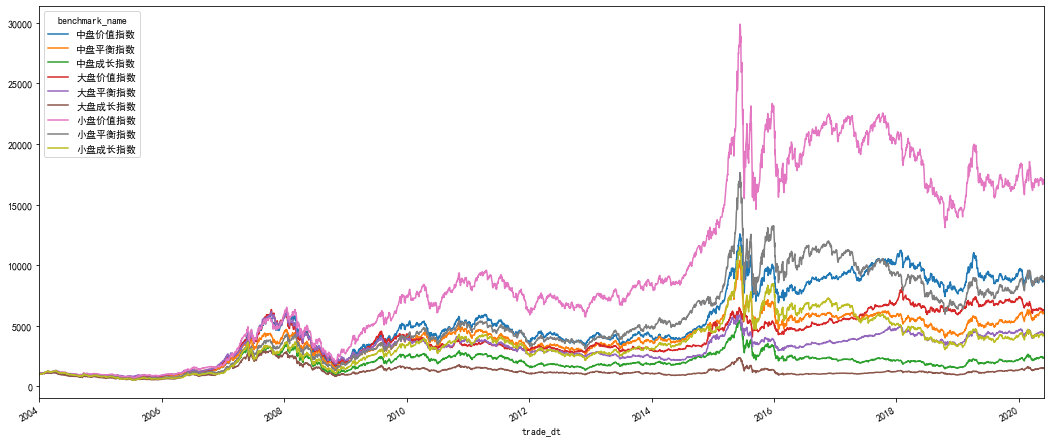

In [19]:
fig, ax = plt.subplots(figsize=(18, 8))
pd.read_sql(
    """
    select d.benchmark_name,trade_dt,close_
    from index_derivative_price p
    inner join index_derivative_description d on p.benchmark_code=d.benchmark_code
    where p.benchmark_code in ('ff3_sg','ff3_sn','ff3_sv','ff3_mg','ff3_mn','ff3_mv','ff3_bg','ff3_bn','ff3_bv')
    """,
    get_sql_engine('postgres')
).pivot('trade_dt','benchmark_name','close_').rename(index=pd.to_datetime).plot(ax=ax)
ax.autoscale(axis='x', tight=True)

# 3. 多空因子合成

根据前一节计算的多头因子收益，计算日收益，并按照以下方式合成日频因子收益

$$ r_{SMB} = \frac{(r_{SG}+r_{SN}+r_{SV})-(r_{BG}+r_{BN}+r_{BV})}{3} $$

$$ r_{HML} = \frac{(r_{SV}+r_{MV}+r_{BV})-(r_{SG}+r_{MG}+r_{BG})}{3} $$

则累计收益曲线

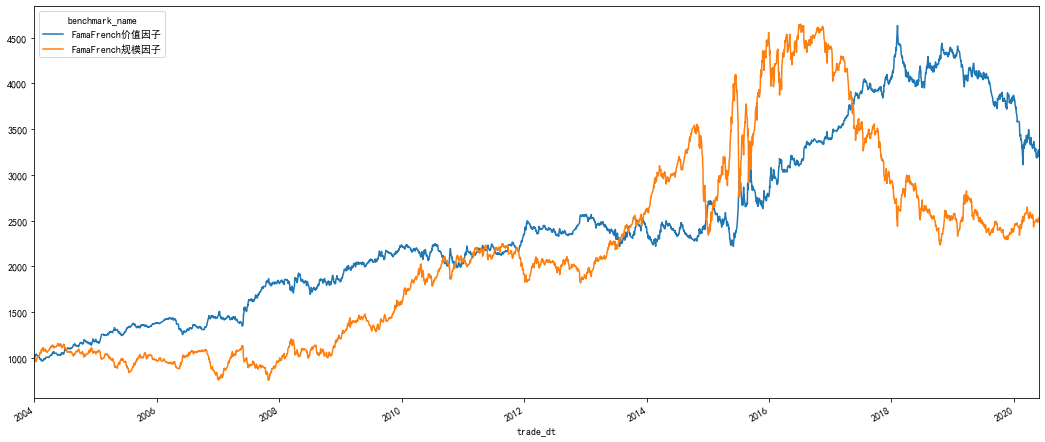

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))
pd.read_sql(
    """
    select d.benchmark_name,trade_dt,close_
    from index_derivative_price p
    inner join index_derivative_description d on p.benchmark_code=d.benchmark_code
    where p.benchmark_code in ('ff3_smb','ff3_hml')
    """,
    get_sql_engine('postgres')
).drop_duplicates(subset=['trade_dt','benchmark_name']).pivot('trade_dt','benchmark_name','close_').rename(index=pd.to_datetime).plot(ax=ax)
ax.autoscale(axis='x', tight=True)